In [1]:
import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy import stats

In [2]:
plt.rcParams.update({"font.family":"Reem Kufi"})
IMAGE = image.imread("uncannyxmen.png")

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

In [4]:
df_char_vis = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-06-30/character_visualization.csv'
)

In [5]:
df_best_chars = pd.DataFrame({
    "rank": np.linspace(1, 10, num=10),
    "char_popular": ["Wolverine", "Magneto", "Nightcrawler", "Gambit",
                     "Storm", "Colossus", "Phoenix", "Professor X", 
                     "Iceman", "Rogue"]
})

In [6]:
# When 'character' contains one of 'char_popular',replace it with 'chacarter'
# so it is possible to merge 'df_char_vis' and 'df_best_chars'
for char in df_best_chars["char_popular"]:
    idxs = df_char_vis["character"].str.contains(char)
    df_char_vis.loc[idxs, "character_join"] = char

In [7]:
## top 5 most popular X-Men characters
## source: https://www.ranker.com/list/best-x-men-characters/ranker-comics
df_best_stream = (
    pd.merge(df_char_vis, df_best_chars, left_on="character_join", right_on="char_popular")
    .groupby(["character", "char_popular", "costume", "rank", "issue"]).agg(
        speech = ("speech", sum),
        thought = ("thought", sum),
        narrative = ("narrative", sum),
        depicted = ("depicted", sum),
    )
    .query("rank <= 5")
    .query("issue < 281")
    .reset_index()
)
df_best_stream

,character,char_popular,costume,rank,issue,speech,thought,narrative,depicted
0,Gambit = Name Unknown,Gambit,Costume,4.0,97,0,0,0,0
1,Gambit = Name Unknown,Gambit,Costume,4.0,98,0,0,0,0
2,Gambit = Name Unknown,Gambit,Costume,4.0,99,0,0,0,0
3,Gambit = Name Unknown,Gambit,Costume,4.0,100,0,0,0,0
4,Gambit = Name Unknown,Gambit,Costume,4.0,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1835,Wolverine = Logan,Wolverine,Non-Costume,1.0,276,9,0,0,14
1836,Wolverine = Logan,Wolverine,Non-Costume,1.0,277,0,0,0,0
1837,Wolverine = Logan,Wolverine,Non-Costume,1.0,278,0,0,0,0
1838,Wolverine = Logan,Wolverine,Non-Costume,1.0,279,0,0,0,0


In [8]:
## factor levels for type of appearance
levels = ["depicted", "speech", "thought", "narrative"]

In [9]:
# df_best_stream_fct = pd.concat([df_best_stream, df_smooth])
df_best_stream_fct = df_best_stream
df_best_stream_fct["costume"] = np.where(
    df_best_stream_fct["costume"] == "Costume", "costumed", "casual"
    
)

df_best_stream_fct["char_costume"] = df_best_stream_fct["char_popular"] + " (" + df_best_stream_fct["costume"] + ")"
df_best_stream_fct = df_best_stream_fct.reset_index(drop=True)

categories = df_best_stream_fct.sort_values(by=["rank","char_costume"])["char_costume"].unique()
df_best_stream_fct["char_costume"] = pd.Categorical(
    df_best_stream_fct["char_costume"],
    categories = categories,
    ordered = True
)

df_best_stream_fct = pd.melt(
    df_best_stream_fct,
    id_vars = ["character", "char_popular", "costume", "rank", "issue", "char_costume"],
    value_vars = ["speech", "thought", "narrative", "depicted"],
    var_name = "parameter",
    value_name = "value"
)
df_best_stream_fct["parameter"] = pd.Categorical(df_best_stream_fct["parameter"], levels)

In [10]:
df_best_stream_fct

,character,char_popular,costume,rank,issue,char_costume,parameter,value
0,Gambit = Name Unknown,Gambit,costumed,4.0,97,Gambit (costumed),speech,0
1,Gambit = Name Unknown,Gambit,costumed,4.0,98,Gambit (costumed),speech,0
2,Gambit = Name Unknown,Gambit,costumed,4.0,99,Gambit (costumed),speech,0
3,Gambit = Name Unknown,Gambit,costumed,4.0,100,Gambit (costumed),speech,0
4,Gambit = Name Unknown,Gambit,costumed,4.0,101,Gambit (costumed),speech,0
...,...,...,...,...,...,...,...,...
7355,Wolverine = Logan,Wolverine,casual,1.0,276,Wolverine (casual),depicted,14
7356,Wolverine = Logan,Wolverine,casual,1.0,277,Wolverine (casual),depicted,0
7357,Wolverine = Logan,Wolverine,casual,1.0,278,Wolverine (casual),depicted,0
7358,Wolverine = Logan,Wolverine,casual,1.0,279,Wolverine (casual),depicted,0


In [11]:
pal = [
  "#FFB400", adjust_lightness("#FFB400", 1.25),
  "#C20008", adjust_lightness("#C20008", 1.2),
  "#13AFEF", adjust_lightness("#13AFEF", 1.25),
  "#8E038E", adjust_lightness("#8E038E", 1.2),
  "#595A52", adjust_lightness("#595A52", 1.25)
]

In [12]:
df_best_stream_fct = df_best_stream_fct.sort_values(by = ["char_costume", "issue"])
df_best_stream_fct = df_best_stream_fct.groupby(["char_costume", "issue", "parameter"]).agg(
    value = ("value", np.mean)
).reset_index()

df_depicted = df_best_stream_fct.query("parameter == 'depicted'")

In [13]:
GREY25 = "#404040"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY88 = "#e0e0e0"
GREY95 = "#f2f2f2"

In [14]:
issues = [
    df_depicted[df_depicted["char_costume"] == char]["issue"].values
    for char in df_depicted["char_costume"].unique()
]
values = [
    df_depicted[df_depicted["char_costume"] == char]["value"].values
    for char in df_depicted["char_costume"].unique()
]

grid = np.linspace(70, 320, num=1000)

In [15]:
def gaussian_smooth(x, y, grid, h):
    weights = np.transpose([stats.norm.pdf(grid, m, h) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

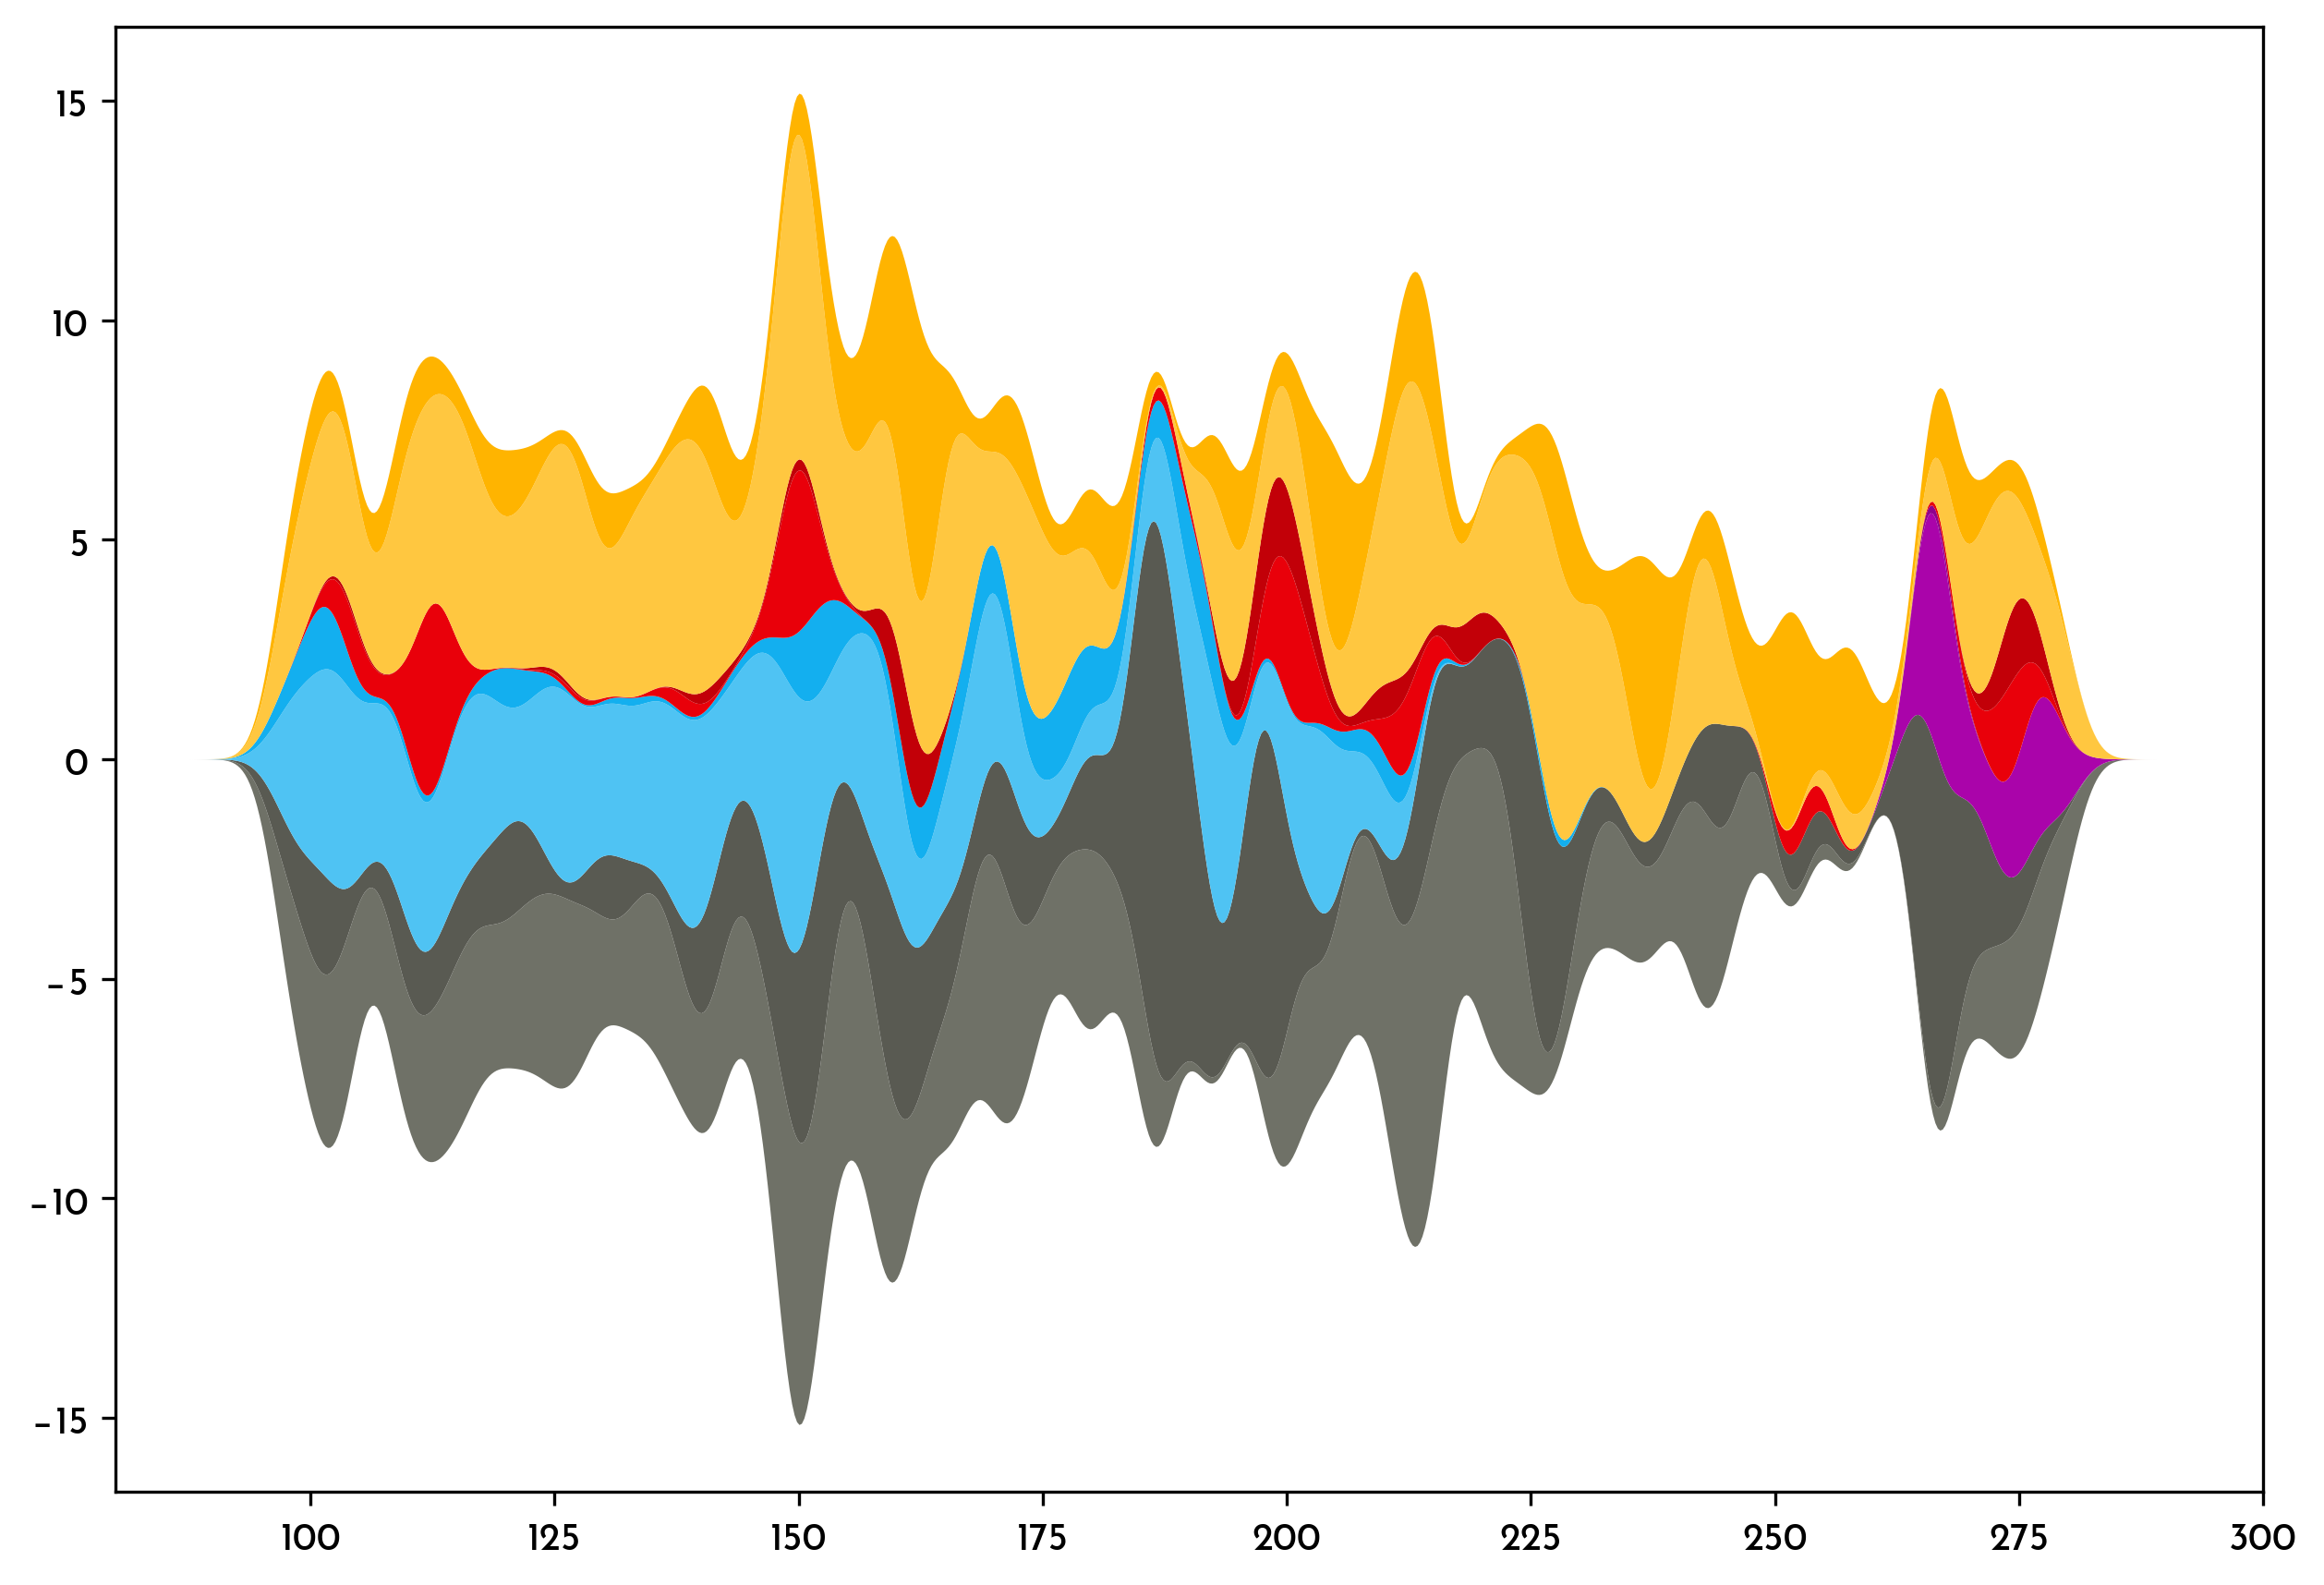

In [16]:
# Basic stacked area chart.
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)

values_smoothed = [gaussian_smooth(x, y, grid, h=2) for x, y in zip(issues, values)]
ax.stackplot(grid, values_smoothed[::-1], colors = pal[::-1], baseline="sym")

ax.set_xlim(80, 300);

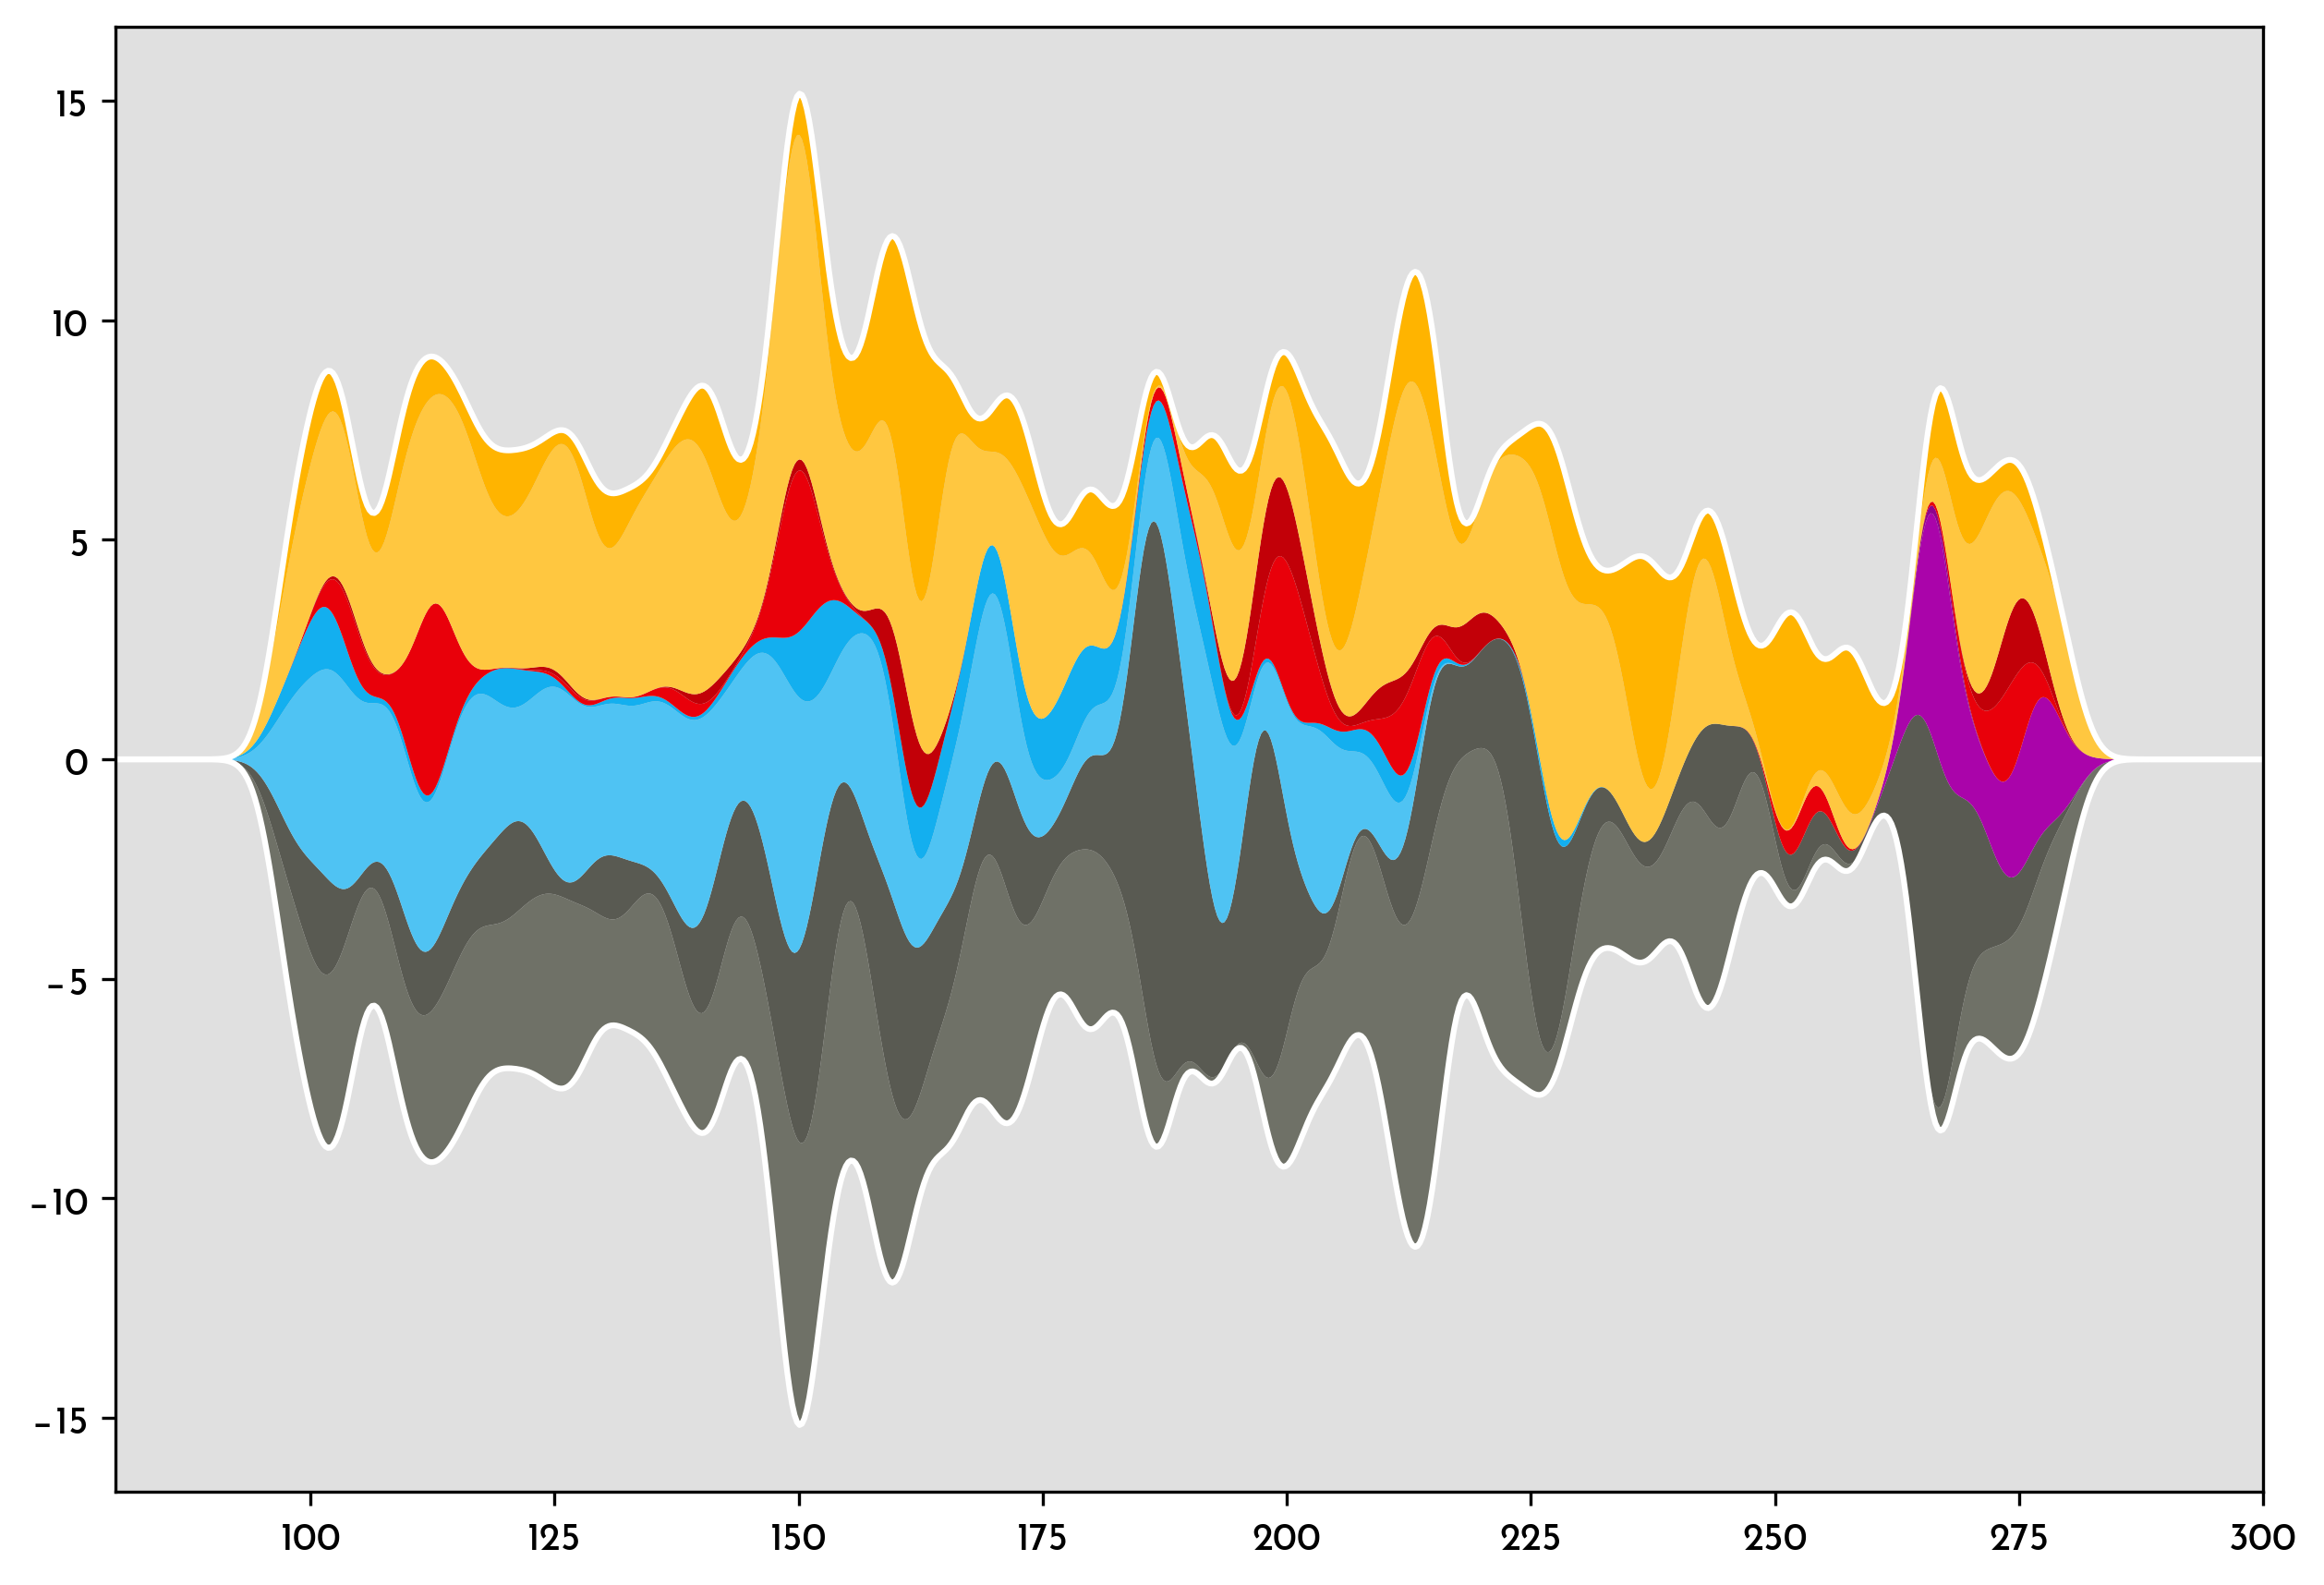

In [17]:
ax.set_facecolor(GREY88)
line = np.array(values_smoothed).sum(0)
ax.plot(grid, line / 2, lw=1.5, color="white")
ax.plot(grid, -line / 2, lw=1.5, color="white")
fig

In [18]:
XTICKS = [97, 125, 150, 175, 200, 225, 250, 280]

In [19]:
def streamgraph(df, parameter, ax, grid, h=2):
    df = df[df["parameter"] == parameter]
    issues = [
        df[df["char_costume"] == char]["issue"].values
        for char in df["char_costume"].unique()
    ]
    values = [
        df[df["char_costume"] == char]["value"].values
        for char in df["char_costume"].unique()
    ]

    values_smoothed = [gaussian_smooth(x, y, grid, h=h) for x, y in zip(issues, values)]
    ax.stackplot(grid, values_smoothed[::-1], colors = pal[::-1], baseline="sym")
    
    # Add border lines
    line = np.array(values_smoothed).sum(0)
    ax.plot(grid, line / 2, lw=1.5, color="white")
    ax.plot(grid, -line / 2, lw=1.5, color="white")
    
    for x in XTICKS:
        ax.axvline(x, color=GREY88, ls=(0, (1, 2)), zorder=10)
    
    ax.set_facecolor(GREY88)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    ax.spines["left"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.spines["right"].set_color("none")
    ax.spines["top"].set_color("none")

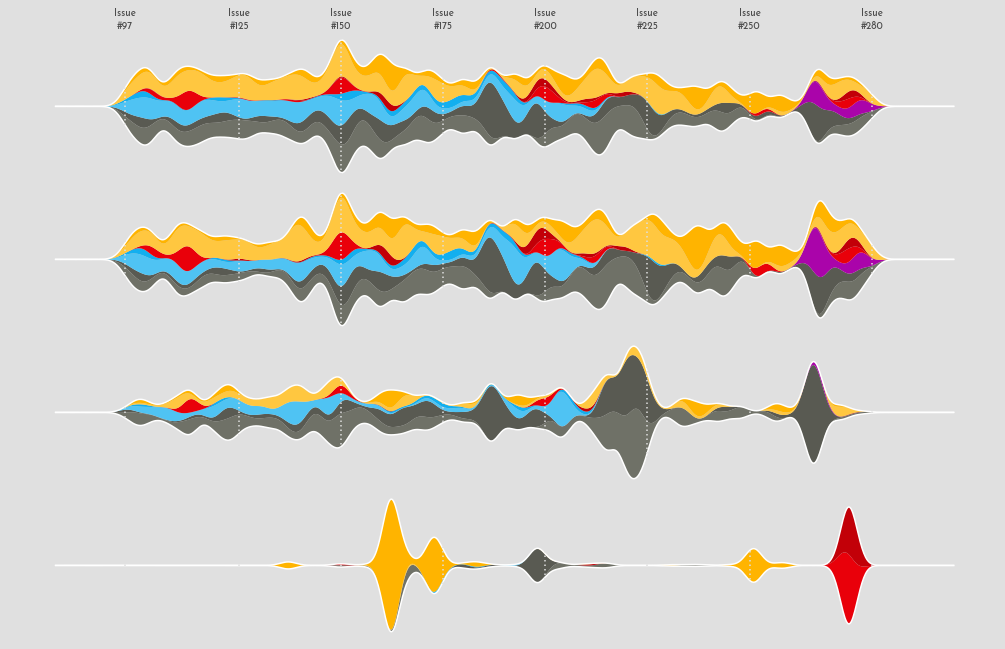

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(14, 10.5), sharex=True)
fig.patch.set_facecolor(GREY88)

grid = np.linspace(80, 300, num=1000)
for idx, parameter in enumerate(["depicted", "speech", "thought", "narrative"]):
    streamgraph(df_best_stream_fct, parameter, ax[idx], grid)

fig.subplots_adjust(left=0.01, bottom=0.1, right=0.99, top=0.9, hspace=0.05)


ax[0].xaxis.set_visible(True)
ax[0].tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=True, length=0)
ax[0].set_xticks(XTICKS)
ax[0].set_xticklabels([f"Issue\n#{x}" for x in XTICKS], color=GREY30);

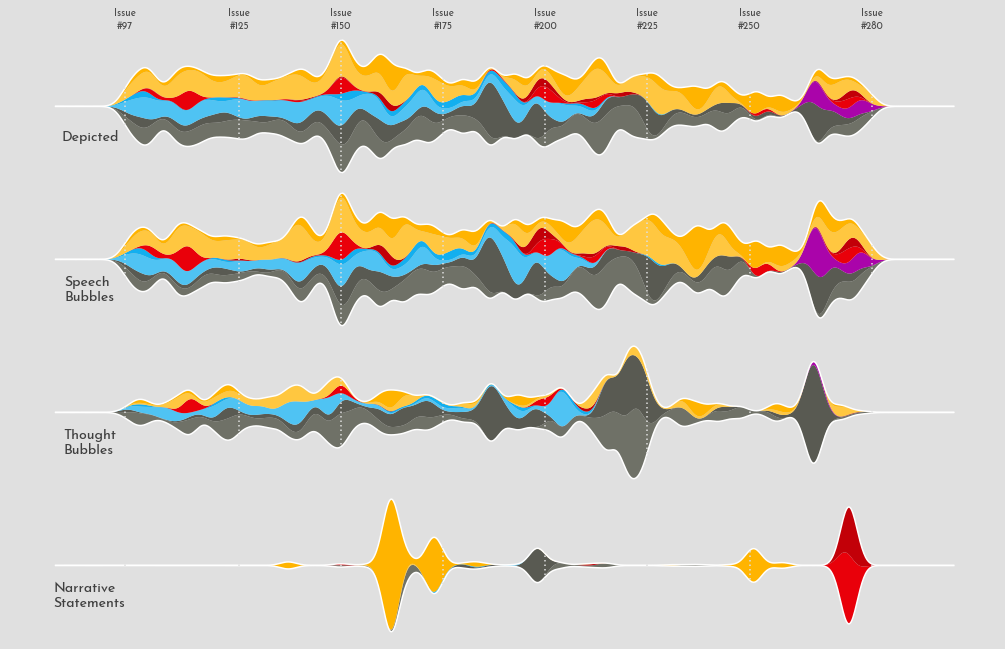

In [21]:
labels = pd.DataFrame({
    "issue": [78] * 4,
    "value": [-21, -19, -14, -11],
    "parameter": pd.Categorical(levels, levels),
    "label": ["Depicted", "Speech\nBubbles", "Thought\nBubbles", "Narrative\nStatements"]
})

for idx, row in labels.iterrows():
    ax[idx].text(
        0.08, 
        0.3, 
        row["label"], 
        ha="center",
        va="center",
        ma="left",
        color=GREY25,
        size=14,
        weight=900,
        transform=ax[idx].transAxes,

    )
fig

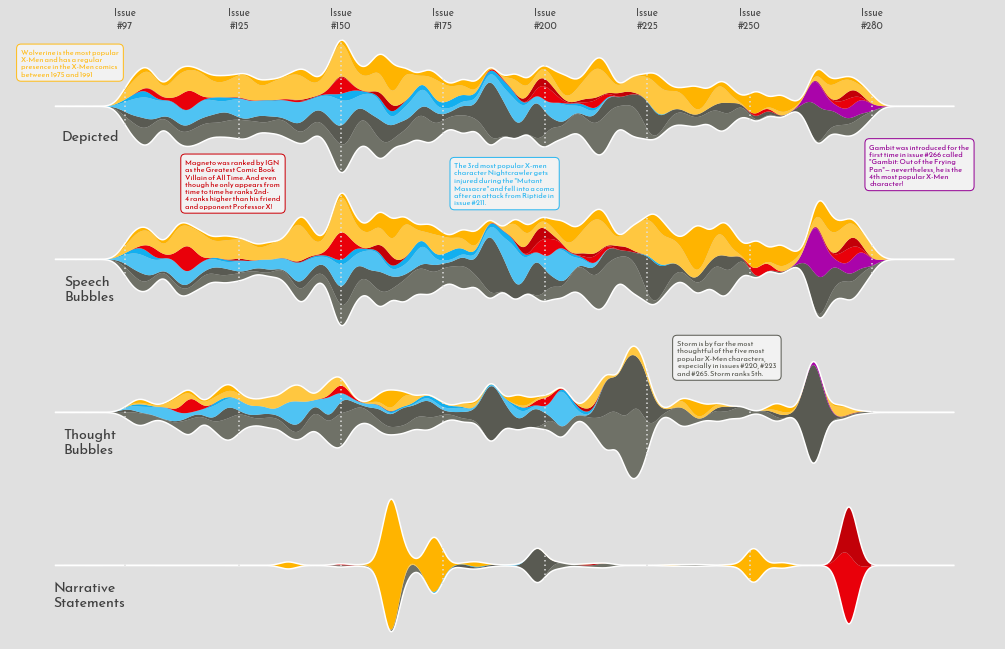

In [22]:
TEXTS = [
    {
        "text": 'Gambit was introduced for the\nfirst time in issue #266 called\n"Gambit: Out of the Frying\nPan"— nevertheless, he is the\n4th most popular X-Men\ncharacter!',
        "ax": 0,
        "x": 0.92,
        "y": 0.1,
        "color": adjust_lightness("#8E038E", 1.05)
    },
    {
        "text": 'Wolverine is the most popular\nX-Men and has a regular\npresence in the X-Men comics\nbetween 1975 and 1991',
        "ax": 0,
        "x": 0.06,
        "y": 0.80,
        "color": adjust_lightness("#FFB400", 1.1)
    },
    {
        "text": 'Storm is by far the most\nthoughtful of the five most\npopular X-Men characters,\n especially in issues #220, #223\nand #265. Storm ranks 5th.',
        "ax": 2,
        "x": 0.725,
        "y": 0.875,
        "color": adjust_lightness("#595A52", 1.01)
    },
    {
        "text": "Magneto was ranked by IGN\nas the Greatest Comic Book\nVillain of All Time. And even\nthough he only appears from\ntime to time he ranks 2nd-\n4 ranks higher than his friend\nand opponent Professor X!",
        "ax": 1,
        "x": 0.225,
        "y": 1.02,
        "color": adjust_lightness("#C20008", 1.05)
    },
    {
        "text": 'The 3rd most popular X-men\ncharacter Nightcrawler gets\ninjured during the "Mutant\nMassacre" and fell into a coma\nafter an attack from Riptide in\nissue #211.',
        "ax": 1,
        "x": 0.5,
        "y": 1.02,
        "color": adjust_lightness("#13AFEF", 1.1)
    },
    
]

for d in TEXTS:
    ax[d["ax"]].text(
        x = d["x"],
        y = d["y"],
        s = d["text"], 
        ha="center",
        va="center",
        ma="left",
        fontsize=7.5,
        color=d["color"],
        bbox=dict(
            boxstyle="round", 
            facecolor=GREY95,
            edgecolor=d["color"],
            pad=0.6
        ),
        transform=ax[d["ax"]].transAxes,
        zorder=999
    )
    fig.texts.append(ax[d["ax"]].texts.pop())
fig

In [23]:
names = ["Wolverine", "Magneto", "Nightcrawler", "Gambit", "Storm"]
costumes = ["casual", "costumed"]
labels = [f"{name} ({costume})" for name in names for costume in costumes]

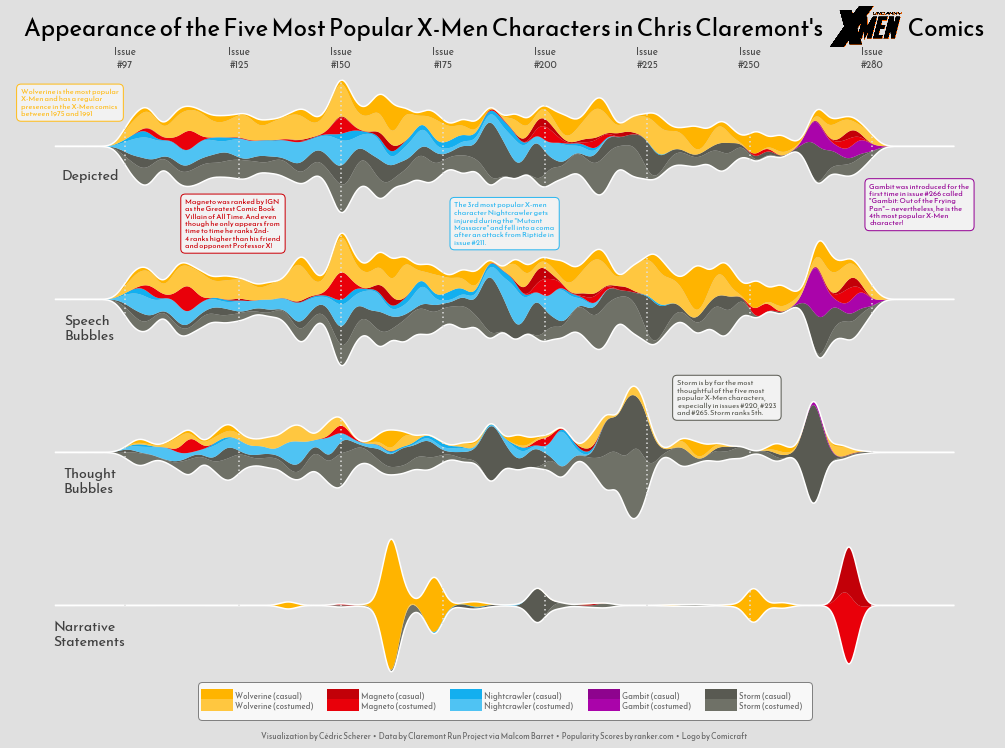

In [24]:
years = [2016, 2017, 2018, 2019, 2020, 2021]
def get_handle(label, color):
    line = Line2D(
        [0], 
        [0], 
        color=color, 
        label=label,
        lw=12
    )
    return line

handles = [get_handle(label, color) for label, color in zip(labels, pal)]

legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.07],
    edgecolor=GREY40,
    labelspacing=0.15,
    loc="center", 
    ncol=5
)

for text in legend.get_texts():
    text.set_fontsize(8)   
    text.set_color(GREY40)

legend.get_frame().set_boxstyle("round", rounding_size=0.4, pad=0.5)    

fig.text(
    0.5,
    0.95,
    "Appearance of the Five Most Popular X-Men Characters in Chris Claremont's                           Comics",
    fontsize=24,
    fontweight="bold",
    ha="center"
)

fig.text(
    0.5, 
    0.02, 
    "Visualization by Cédric Scherer  •  Data by Claremont Run Project via Malcom Barret  •  Popularity Scores by ranker.com  •  Logo by Comicraft",
    color=GREY40,
    fontsize=8,
    ha="center"

)


# Create annotation box to place image.
# It will be added at (1, 6.75) in data coordinates.
ab = AnnotationBbox(
    OffsetImage(IMAGE, zoom=0.20), 
    (0.815, 0.955), 
    xycoords="figure fraction", 
    box_alignment=(0, 0.5),
    pad=0, 
    frameon=False
)

# Add the annotation box into the axis
fig.add_artist(ab)

fig

You can run `fig.savefig("xmen.png", dpi=300)`.